## Advanced Lane Finding Project

This project is a step forward from the Lane Finding Project, The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
***
The aim of this project is to develop a pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). We will start off by using the same layout for project 1 and enhance it using the techniques learned during the later lessons.

---
**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.

This is it!

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the code cell below.  

Using the code provided in the examples for this project, I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

'''For a given path, seek through calibration images and return images detected
successfully, along with their object points and image points.'''
def get_chessboard_corners(pathname, chessboard_size=(9, 6)):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chessboard_size[1]*chessboard_size[0],3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    paths = [] # Path of the successfully processed calibration image

    # Make a list of calibration images
    images = glob.glob(pathname)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            paths.append(fname)

    return (paths, objpoints, imgpoints)

cal_img_path = './camera_cal/calibration*.jpg'
print('Retrieving chessboard corners for images in \'{}\''.format(cal_img_path))
image_paths, objpoints, imgpoints = get_chessboard_corners(cal_img_path)
print('Calibration images processed.')

Retrieving chessboard corners for images in './camera_cal/calibration*.jpg'
Calibration images processed.


In [2]:
'''Draw and display corners found for images.'''
def display_corners(images, objpoints, imgpoints, chessboard_size=(9, 6)):
    # Draw and display the corners
    for index, fname in enumerate(images):
        img = cv2.imread(fname)
        img_corners = cv2.drawChessboardCorners(img, chessboard_size, imgpoints[index], True)
        imgplot = plt.imshow(img_corners)
        plt.savefig('./output_images/chessboard_found_corners.png')
        plt.show(imgplot)
        break

# Debugging information for the object and image points:
display_corners(image_paths, objpoints, imgpoints)

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function, displayed below.

In [3]:
'''Calibrates a camera using the given object and image points. Returns the camera matrix and distortion coefficients.'''
def calibrate_camera(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    return mtx, dist

'''Returns an undistorted version of the image, given the camera matrix and distortion coefficients.'''
def undistort_image(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

I applied this distortion correction to one of the test images using the `cv2.undistort()` function and obtained this result:

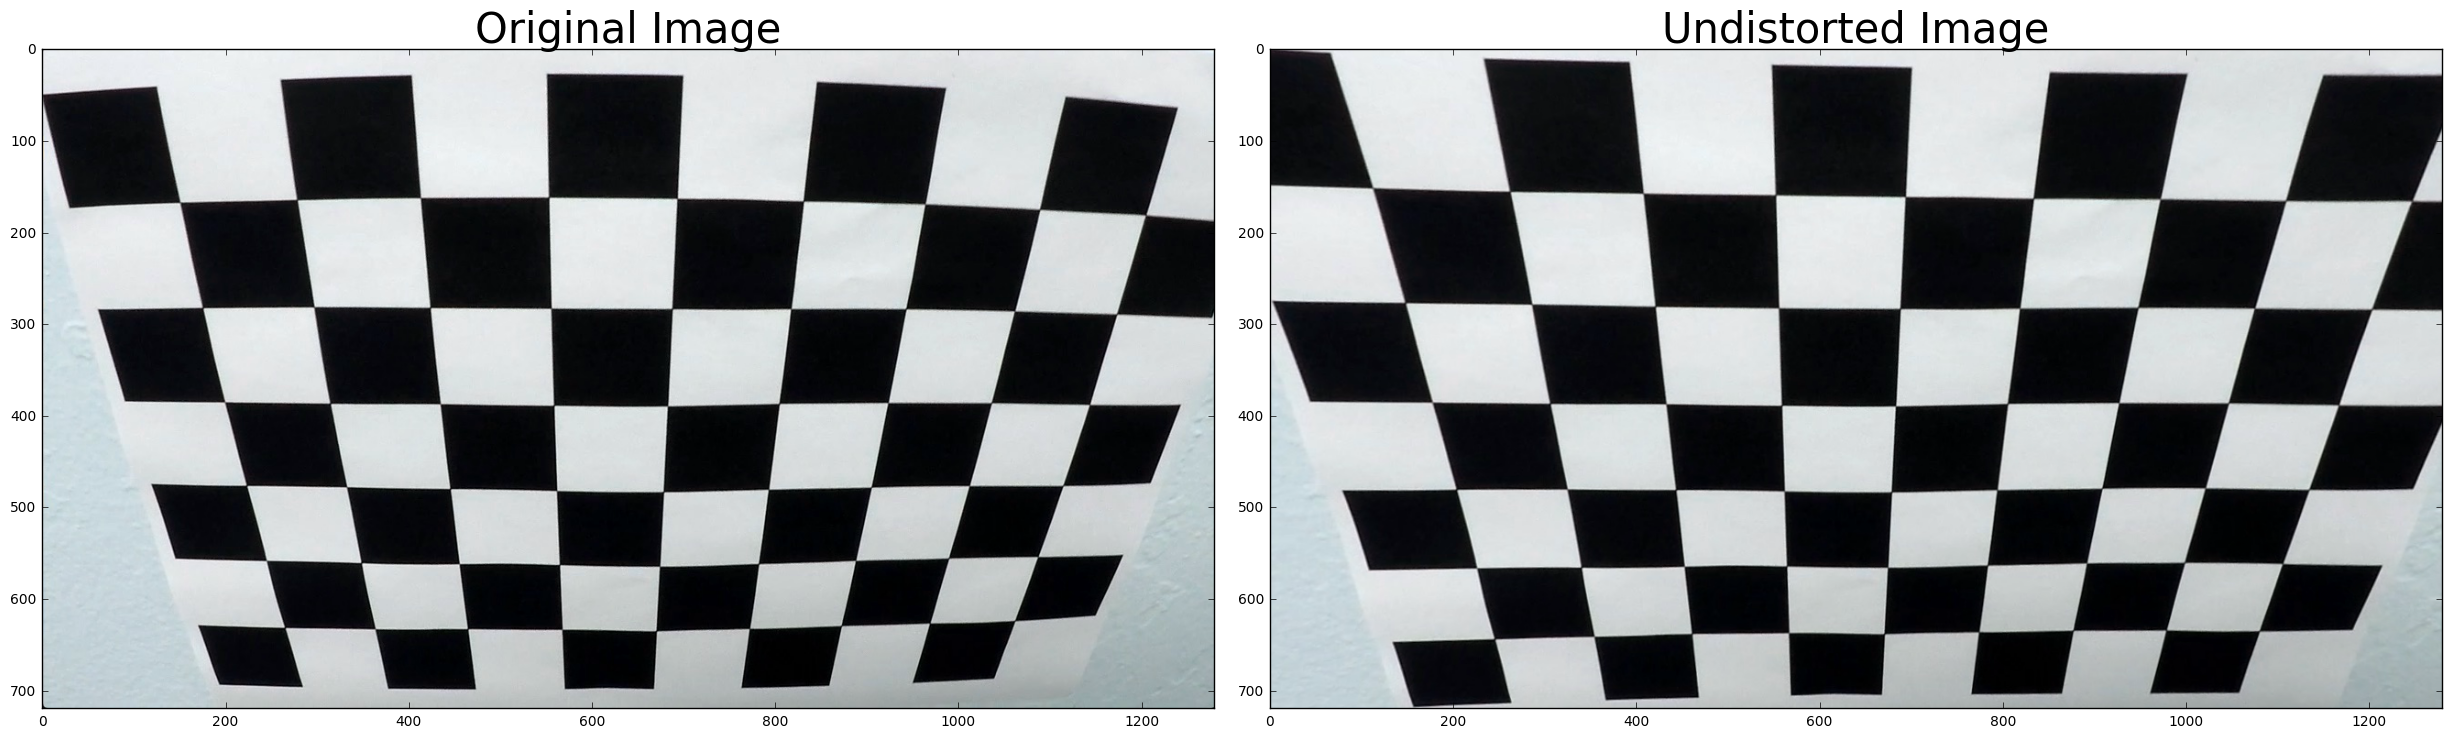

In [4]:
# Read in an image from the calibration set:
img = cv2.imread('./camera_cal/calibration2.jpg')

# Get camera matrix and distortion coefficients with the test image:
mtx, dist = calibrate_camera(img, objpoints, imgpoints)

# Apply the distortion correction to the image:
undistorted = undistort_image(img, mtx, dist)

# Plot the result:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.1)
f.savefig('./output_images/undistort_calibration_test.png')

# Save the results:
import pickle

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./camera_cal/dist_pickle.p", "wb" ) )

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

The image above is a proper example of a distortion-corrected image. I first need to get the camera matrix and distortion coefficients to pass to the undistort function, which then produces the image on the right. If we were to test on one of the provided test images, this would be done as follows:

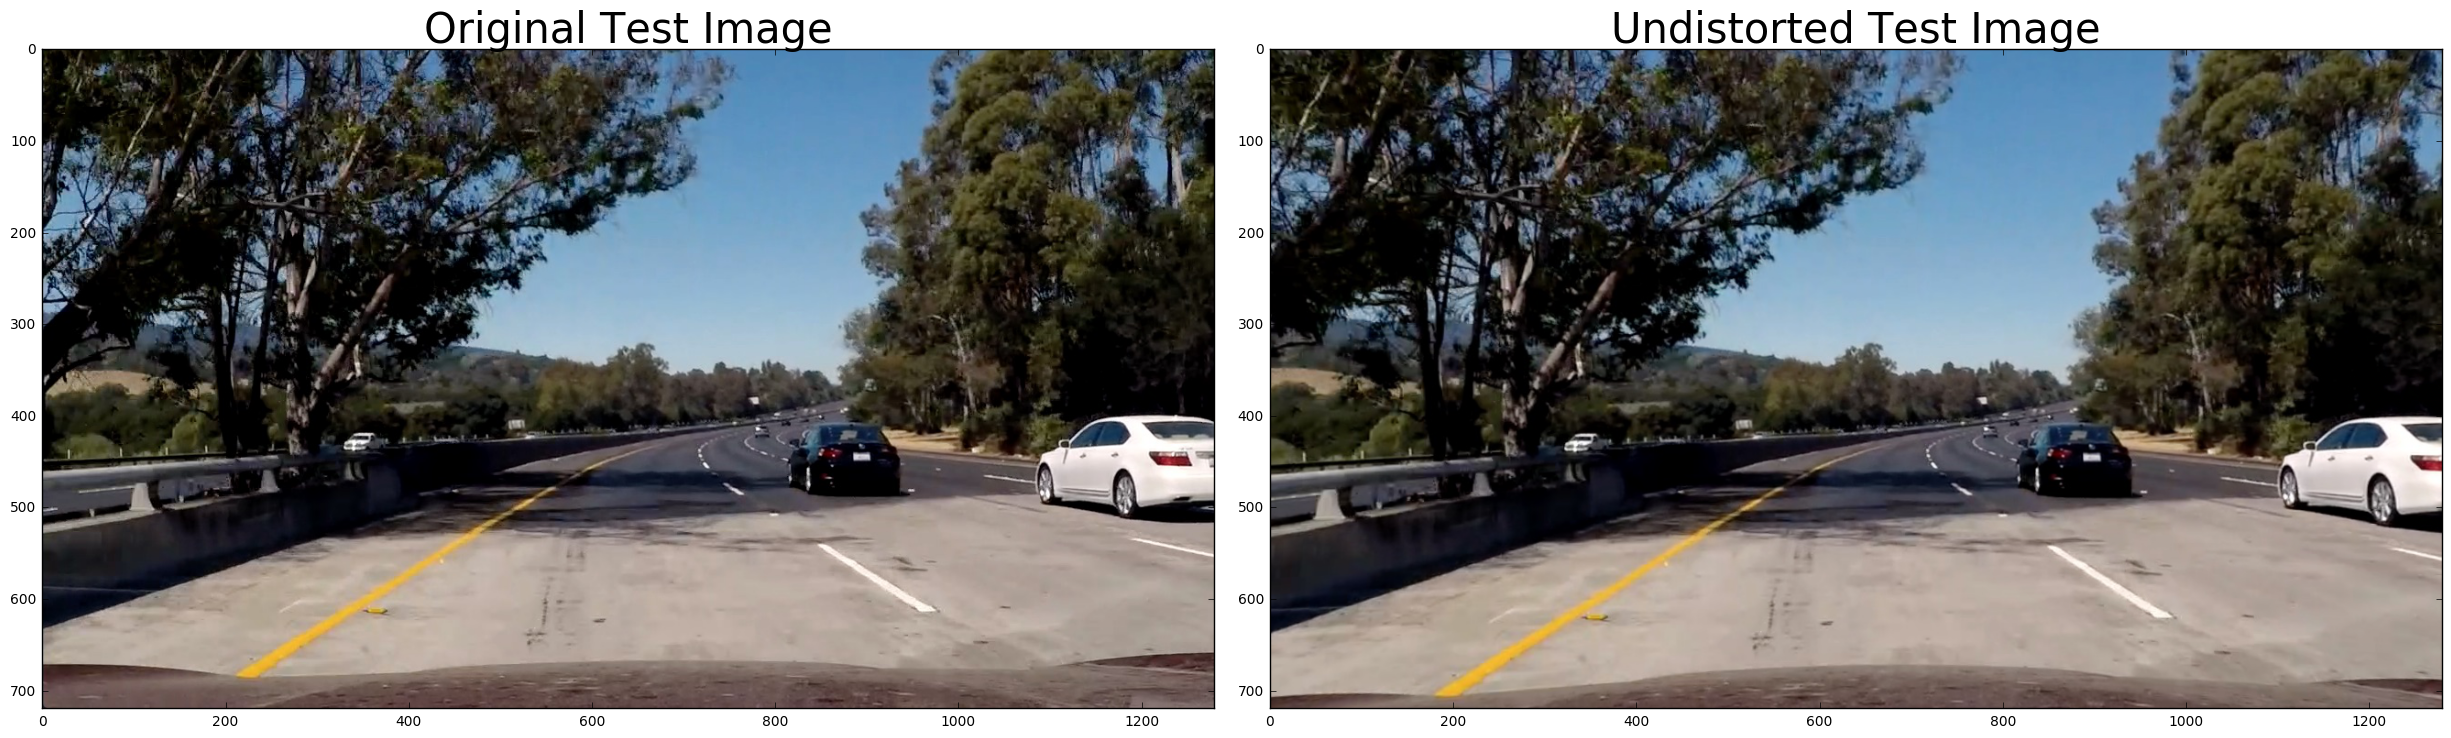

In [5]:
import matplotlib.image as mpimg

#test_img_path = './test_images/straight_lines2.jpg'
test_img_path = './test_images/test5.jpg'
test_img = mpimg.imread(test_img_path)

undistort_test = undistort_image(test_img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Test Image', fontsize=30)
ax2.imshow(undistort_test)
ax2.set_title('Undistorted Test Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.1)
f.savefig('./output_images/undistort_test_image.png')

Although, to be honest, I do not see any difference between the two images, save for some cropping.

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image (thresholding steps in code cell below).

In [6]:
# Image threshold pipeline functions:
# Functions from the lessons:


def abs_sobel_thresh(src_img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output


def mag_thresh(src_img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output


def dir_threshold(src_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


def rgb_binary_threshold_r(src_img, thresh=(200, 255)):
    """Return a binary threshold image of the R channel in RGB color space."""
    R = src_img[:,:,0]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary


def hls_binary_threshold_s(src_img, thresh=(90, 255)):
    """Return a binary threshold image of the S channel in HLS color space."""
    hls = cv2.cvtColor(src_img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary


def combined_threshold(src_img, region=((None, None), (None, None)), args=None):
    """Finds and returns a binary image based on the combination of thresholds.
    Uses an optional region of interest polygon.
    """
    # Comment in/out when (un)used:
    sx_binary = abs_sobel_thresh(src_img, thresh=(20, 100))
    mag_binary = mag_thresh(src_img, thresh=(80, 150))
    dir_binary = dir_threshold(src_img, sobel_kernel=15, thresh=(0.7, 1.2))
    r_binary = rgb_binary_threshold_r(src_img, thresh=(200, 255))
    s_binary = hls_binary_threshold_s(src_img, thresh=(170, 255))
        
    # Combine the binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1) | (r_binary == 1)] = 1
    #combined_binary[(s_binary == 1) | (r_binary == 1) | (mag_binary == 1)] = 1
    #combined_binary[(sx_binary == 1) | (r_binary == 1) | (s_binary == 1)] = 1
    return combined_binary

Here's an example of each binary threshold function, and my combined output for this step:

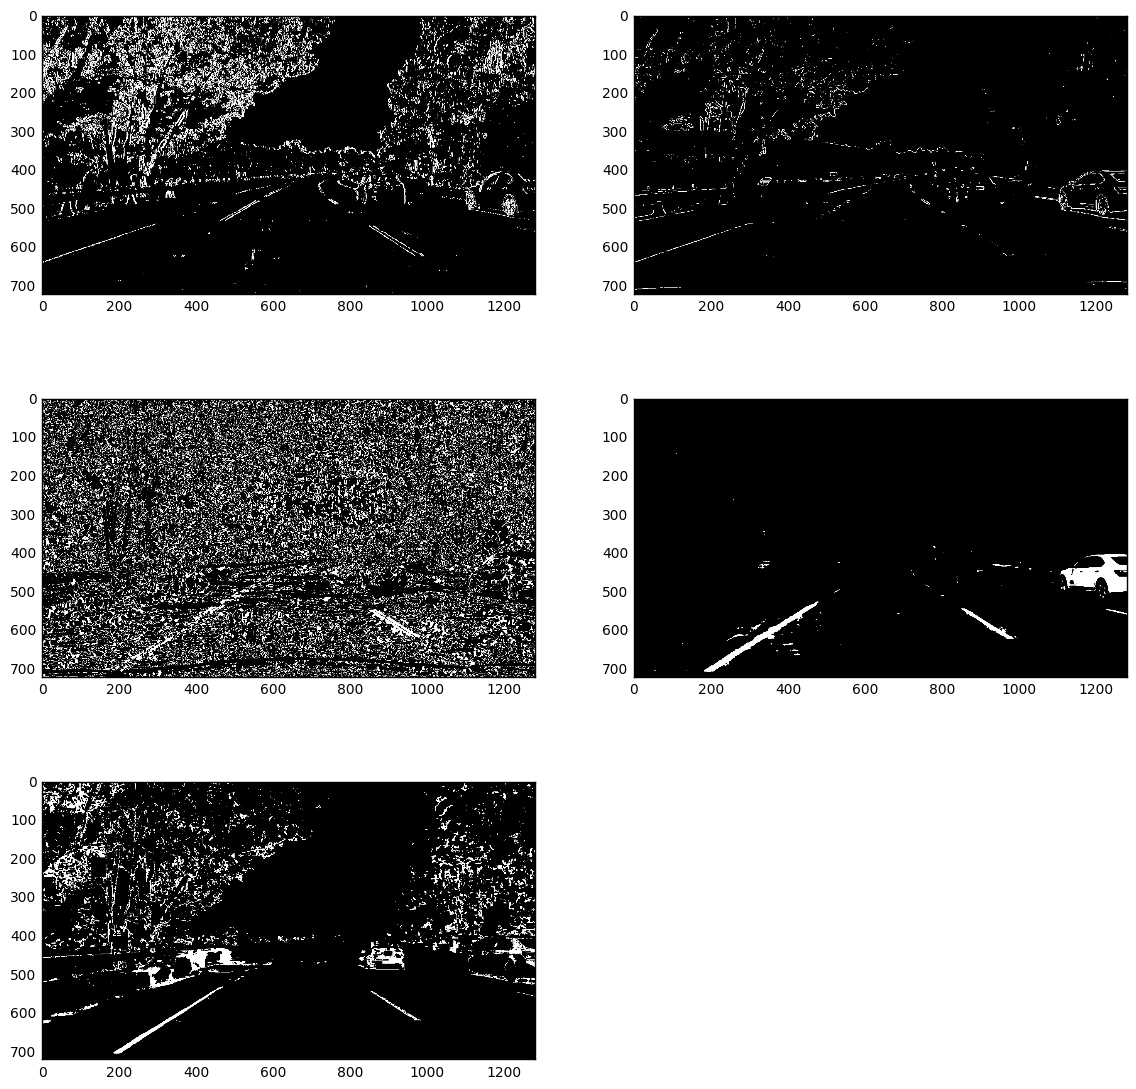

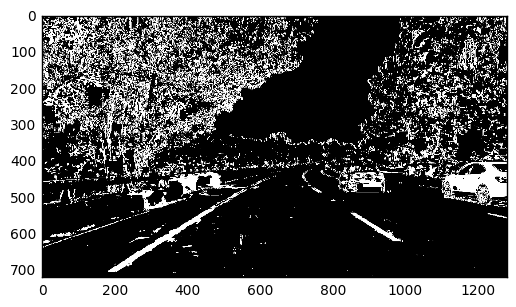

In [7]:
threshold_imgs = []
threshold_imgs.append(abs_sobel_thresh(undistort_test, thresh=(20, 100)))
threshold_imgs.append(mag_thresh(undistort_test, thresh=(80, 150)))
threshold_imgs.append(dir_threshold(undistort_test, sobel_kernel=15, thresh=(0.8, 1.2)))
threshold_imgs.append(rgb_binary_threshold_r(undistort_test, thresh=(200, 255)))
threshold_imgs.append(hls_binary_threshold_s(undistort_test, thresh=(170, 255)))

plt.figure(figsize=(14, 14))
for i in range(0, 5):
    plt.subplot(3, 2, i+1)
    plt.imshow(threshold_imgs[i], cmap='gray')
plt.show()

binary_img_result = combined_threshold(undistort_test)
plt.imshow(binary_img_result, cmap='gray')
plt.savefig('./output_images/binary_image_result.png')
plt.show()

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warper()`, which appears below.

In [8]:
def warper(img, src=None, dst=None, inverse=False):

    img_size = (img.shape[1], img.shape[0])
    if src is None:
        src = np.float32(
            [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 70), img_size[1] / 2 + 100]])
    if dst is None:
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    if not inverse:
        M = cv2.getPerspectiveTransform(src, dst)
    else: # This is actually the calculation of the inverse matrix, Minv.
        M = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

The `warper()` function takes as inputs an image (`img`). The source (`src`) and destination (`dst`) points are hardcoded inside the function. I thought the hardcoded image points in the example writeup for the project worked fine except for a small adjustment in the upper points for the polygon, so I set them as follows:

```
src_points = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 70), img_size[1] / 2 + 100]])
dst_points = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 580, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 710, 460      | 960, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

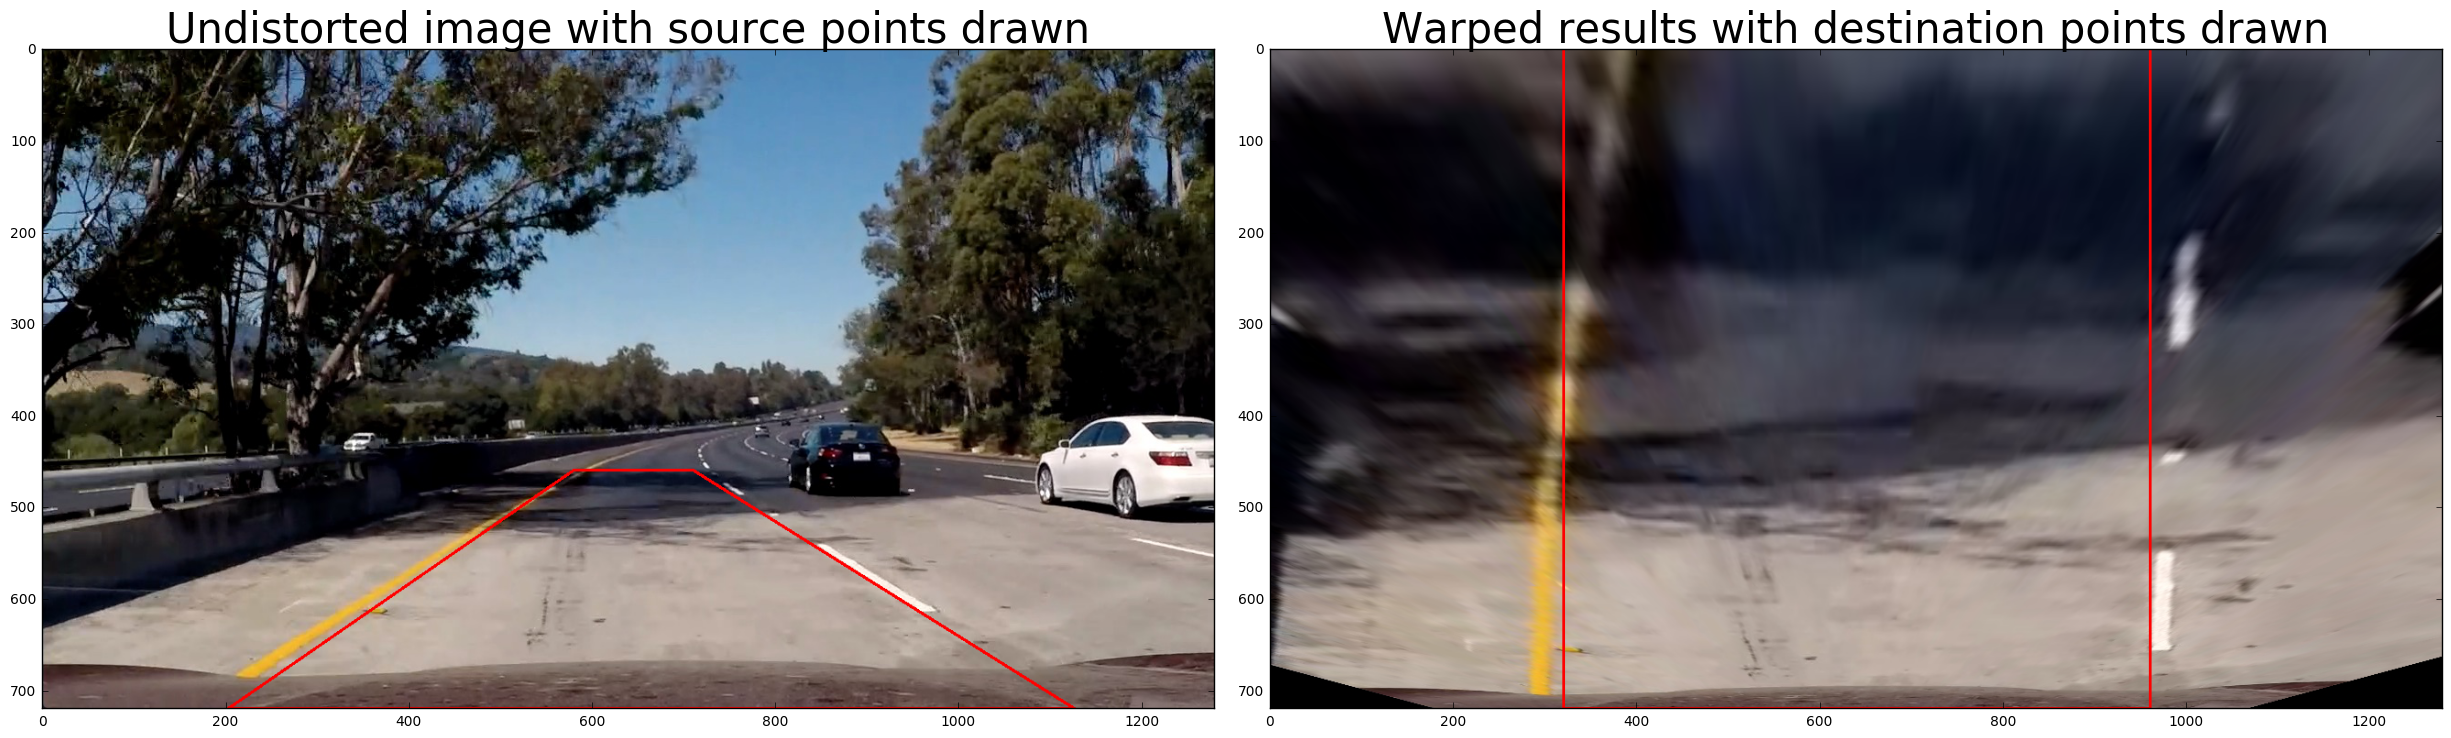

In [9]:
# Grab the image shape
img_size = (test_img.shape[1], test_img.shape[0])

# Hardcoded points (same as in function above)
src_points = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 70), img_size[1] / 2 + 100]])
dst_points = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

# Draw lines in both images:
src_image = np.copy(test_img)
cv2.line(src_image, (src_points[0][0], src_points[0][1]), (src_points[1][0], src_points[1][1]), (255, 0, 0), 2)
cv2.line(src_image, (src_points[1][0], src_points[1][1]), (src_points[2][0], src_points[2][1]), (255, 0, 0), 2)
cv2.line(src_image, (src_points[2][0], src_points[2][1]), (src_points[3][0], src_points[3][1]), (255, 0, 0), 2)
cv2.line(src_image, (src_points[3][0], src_points[3][1]), (src_points[0][0], src_points[0][1]), (255, 0, 0), 2)

dst_image, _ = warper(test_img)
cv2.line(dst_image, (dst_points[0][0], dst_points[0][1]), (dst_points[1][0], dst_points[1][1]), (255, 0, 0), 2)
cv2.line(dst_image, (dst_points[1][0], dst_points[1][1]), (dst_points[2][0], dst_points[2][1]), (255, 0, 0), 2)
cv2.line(dst_image, (dst_points[2][0], dst_points[2][1]), (dst_points[3][0], dst_points[3][1]), (255, 0, 0), 2)
cv2.line(dst_image, (dst_points[3][0], dst_points[3][1]), (dst_points[0][0], dst_points[0][1]), (255, 0, 0), 2)

# Display the results:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(src_image)
ax1.set_title('Undistorted image with source points drawn', fontsize=30)
ax2.imshow(dst_image)
ax2.set_title('Warped results with destination points drawn', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.1)
f.savefig('./output_images/undistort_image_example.png')

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

To build the pipeline for finding the lane-lines, I start with a thresholded and perspective transformed image:

In [10]:
# Using a curved lane image to build the first part of the pipeline:
test_img_path = './test_images/test5.jpg'
test_img = mpimg.imread(test_img_path)
undistort_test = undistort_image(test_img, mtx, dist)

thresholded_img = combined_threshold(test_img)
pers_transf_img, _ = warper(thresholded_img)

plt.imshow(pers_transf_img, cmap='gray')
plt.show()

Then I took a histogram of the lower half of the image, per the lesson on locating the lane lines, like so:

/home/carlos/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


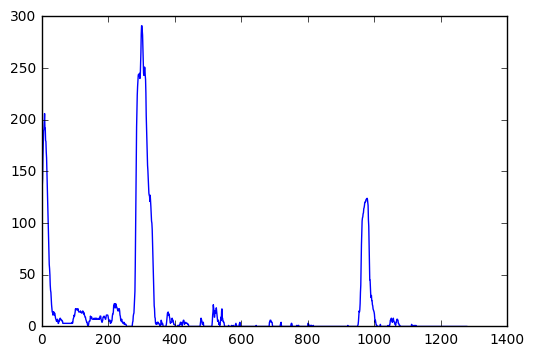

In [11]:
histogram = np.sum(pers_transf_img[pers_transf_img.shape[0]/2:,:], axis=0)
plt.plot(histogram)
plt.savefig('./output_images/lanedetection_histogram_example.png')
plt.show()

I can see that the histogram points out multiple peaks: around x=0, y=205, x=300, y=275 and another one at x=950, y=150, which sort of coincides with the lane lines on the thresholded, perspective-transformed image.

I use the sliding window method pointed out in the same lesson as above, fitting the lane lines with a second order polynomial, with code as follows:

In [12]:
def get_lanes_window(img):
    """Retrieve lane lines based on a sliding-window-based search."""
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img)) * 255

    # Get histogram of lower half of the image:
    histogram = np.sum(img[img.shape[0] / 2:, :], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
        nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
        nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return (leftx, lefty), (rightx, righty), out_img


def fit_polynomial(leftpoints, rightpoints):
    """Fit a second order polynomial to each array of lane points."""
    left_fit = np.polyfit(leftpoints[1], leftpoints[0], 2)
    right_fit = np.polyfit(rightpoints[1], rightpoints[0], 2)
    return left_fit, right_fit

left_points, right_points, out_img = get_lanes_window(pers_transf_img)
left_fit, right_fit = fit_polynomial(left_points, right_points)

/home/carlos/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Then I visualize the result:

In [13]:
def generate_plot_fit(src_img, left_fit, right_fit):
    # Generate x and y values for plotting
    fity = np.linspace(0, src_img.shape[0] - 1, src_img.shape[0])
    fit_leftx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
    fit_rightx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]
    return fity, fit_leftx, fit_rightx


def display_lanes_window(src_img, left_points, right_points, left_fit, right_fit, out_img):
    # Generate x and y values for plotting
    fity, fit_leftx, fit_rightx = generate_plot_fit(src_img, left_fit, right_fit)

    out_img[left_points[1], left_points[0]] = [255, 0, 0]
    out_img[right_points[1], right_points[0]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(fit_leftx, fity, color='yellow')
    plt.plot(fit_rightx, fity, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig('./output_images/lanedetection_sliding_window.png')
    plt.show()

display_lanes_window(pers_transf_img, left_points, right_points, left_fit, right_fit, out_img)

The image seems about right, even with the noise presented in the upper left lane. Now, since this is meant to be processed in a video pipeline, we don't need to use the sliding windows technique to find the lanelines in each frame; we can use the information from the previous frame to more or less guess where the lanelines will be, like so:

In [14]:
# I'm assuming this is the next frame in the video from 'test5.jpg':
test_img_path = './test_images/test6.jpg'
test_img = mpimg.imread(test_img_path)
undistort_test = undistort_image(test_img, mtx, dist)
thresholded_img = combined_threshold(undistort_test)
binary_warped, _ = warper(thresholded_img)

def get_lanes_predicted(img, left_fit, right_fit):
    """Retrieve lane lines based on existing best guess by get_lanes_window."""
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img)) * 255

    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) & (
        nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) & (
        nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return (leftx, lefty), (rightx, righty), out_img

left_points, right_points, out_img = get_lanes_predicted(binary_warped, left_fit, right_fit)
left_fit, right_fit = fit_polynomial(left_points, right_points)

And then plot the result:

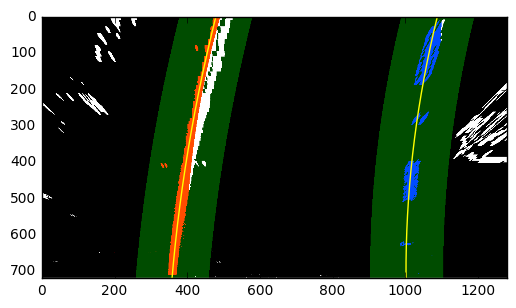

In [15]:
def display_lanes_predicted(img, left_points, right_points, left_fit, right_fit):
    # Generate x and y values for plotting
    fity, fit_leftx, fit_rightx = generate_plot_fit(img, left_fit, right_fit)

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[left_points[1], left_points[0]] = [255, 0, 0]
    out_img[right_points[1], right_points[0]] = [0, 0, 255]

    margin = 100
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin, fity]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_leftx+margin, fity])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([fit_rightx-margin, fity]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_rightx+margin, fity])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(fit_leftx, fity, color='yellow')
    plt.plot(fit_rightx, fity, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig('./output_images/lanedetection_previous_detection.png')
    plt.show()

display_lanes_predicted(binary_warped, left_points, right_points, left_fit, right_fit)

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

To calculate the radius of curvature, I used code as follows:

In [16]:
def calculate_radius_pixels(left_fit, right_fit):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, 719, num=720)  # to cover same y-range as image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])
    return left_curverad, right_curverad

left_curverad, right_curverad = calculate_radius_pixels(left_fit, right_fit)
print(left_curverad, right_curverad)

4379.51665289 2857.41594637


These values are in pixel space, not meters, so we use a conversion based on standard U.S. lane widths:

In [17]:
def calculate_radius_meters(left_points, right_points):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, 719, num=720)  # to cover same y-range as image
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_points[1] * ym_per_pix, left_points[0] * xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_points[1] * ym_per_pix, right_points[0] * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    return left_curverad, right_curverad

# Now our radius of curvature is in meters
left_curverad, right_curverad = calculate_radius_meters(left_points, right_points)
print(left_curverad, 'm', right_curverad, 'm')

1423.43996065 m 938.474261032 m


Also, one thing that's missing from the rubric itself, but I thought would be interesting to add, is the distance-from-center calculation, as follows (Thanks to Rushabh Shah on the '#p-advanced-lane-lines' channel on Slack):

In [18]:
def calculate_center_offset(src_img, left_fit, right_fit):
    _, fit_leftx, fit_rightx = generate_plot_fit(src_img, left_fit, right_fit)
    screen_middel_pixel = src_img.shape[1]/2

    xm_per_pix = 3.7 / 700
    
    left_lane_pixel = fit_leftx[::-1][0]    # x position for left lane
    right_lane_pixel = fit_rightx[::-1][0]   # x position for right lane
    car_middle_pixel = int((right_lane_pixel + left_lane_pixel)/2)
    screen_off_center = screen_middel_pixel-car_middle_pixel
    meters_off_center = xm_per_pix * screen_off_center
    return meters_off_center

meters_off_center = calculate_center_offset(test_img, left_fit, right_fit)
print("Car is {} off center.".format(meters_off_center))

Car is -0.21142857142857144 off center.


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in the code cell below:

In [19]:
def plot_lanelines(warped_img, orig_image, left_fit, right_fit):
    fity, fit_leftx, fit_rightx = generate_plot_fit(warped_img, left_fit, right_fit)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Calculate the inverse matrix to use in next line: 
    _, Minv = warper(warped_img, inverse=True)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped_img.shape[1], warped_img.shape[0])) 

    # Combine the result with the original image
    lane_image = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)
    return lane_image

result = plot_lanelines(binary_warped, undistort_test, left_fit, right_fit)

Here is an example of my result on a test image:

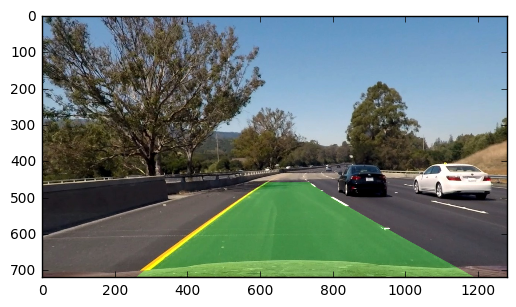

In [20]:
plt.imshow(result)
plt.show()
plt.imsave('./output_images/road_marked_lane.png', result)

---
To summarize, here is the working pipeline (along with helper functions):

In [21]:
def overlay_stats(raw_img, lane_curvature=(None, None), center_offset=None):
    return None


def pipeline(img=None, mtx=None, dist=None, left_fit=None, right_fit=None):
    undistort = undistort_image(img, mtx, dist)
    thresholded_img = combined_threshold(undistort)
    pers_transf_img, _ = warper(thresholded_img)

    # if this is the first prediction or lines are not good enough, search
    # via windows:
    # question: what indicates a bad prediction? Parallelism between lane lines?
    if left_fit is None or right_fit is None:
        left_points, right_points, out_img = get_lanes_window(pers_transf_img)
    # otherwise, search via previously predicted:
    else:
        left_points, right_points, out_img = get_lanes_predicted(pers_transf_img, left_fit, right_fit)

    # Fit a polynomial to both point arrays:
    left_fit, right_fit = fit_polynomial(left_points, right_points)

    # Get helpful stats:
    left_curve, right_curve = calculate_radius_meters(left_points, right_points)
    offset = calculate_center_offset(pers_transf_img, left_fit, right_fit)

    # Now draw the lanes and overlay the stats onto the original image:
    lane_img = plot_lanelines(pers_transf_img, img, left_fit, right_fit)
    stats_img = overlay_stats(lane_img, (left_curve, right_curve), offset)

    # processed_img = np.copy(lane_img) # remove this after overlay function is done
    return lane_img

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video_processed.mp4). You can also run the cell below and have it process and play the video.

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines drawn on lanes)
    result = pipeline(image, mtx=mtx, dist=dist)
    return result

project_output = 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [06:14<00:00,  3.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 10min, sys: 11.2 s, total: 10min 11s
Wall time: 6min 15s


---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.